# Projet de fouille de donnees

## 0.Importation des jeux de donnees

In [1]:
#Importation des bibliotheques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from collections import defaultdict
import datetime
import gzip
import pyarrow as pa
import pyarrow.csv as pv
import pyarrow.parquet as pq
import polars as pl


La problematique etant le volume des donnees, nous allons importer puis convertir dans le format parquet. Ce format permet de reduire le volume et facilite l'exploration des donnees avec des ressources limitees.

### Chargement et transformation des donnees en format parquet

In [3]:
#Importation du jeu de donnees "redteam"
#redteam.txt.gz : Evenements de compromission etiquetes representant des comportements malveillants

df = pl.scan_csv(
    'redteam.txt.gz',
    has_header=False,
    new_columns=['time', 'user@domain', 'source_computer', 'destination_computer']
).sink_parquet('redteam.parquet')

In [ ]:
#Importation du jeu de donnees "dns"
#dns.txt.gz : Requetes DNS collectees sur les serveurs DNS internes

df = pl.scan_csv(
    'dns.txt.gz',
    has_header=False,
    new_columns=['time', 'source_computer', 'computer_resolved']
).sink_parquet('dns.parquet')


In [ ]:
#Importation du jeu de donnees "flows"
#flows.txt.gz : Donnees de flux reseau collectees sur les routeurs centraux

df = pl.scan_csv(
    'flows.txt.gz',
    has_header=False,
    new_columns=['time', 'duration', 'source_computer', 'source_port', 
                'destination_computer', 'destination_port', 'protocol', 
                'packet_count', 'byte_count']
).sink_parquet('flows.parquet')


In [ ]:
#Importation du jeu de donnees "proc"
#proc.txt.gz : Evenements de demarrage/arret de processus sur ordinateurs Windows

df = pl.scan_csv(
    'proc.txt.gz',
    has_header=False,
    new_columns=['time', 'user@domain', 'computer', 'process_name', 'start_end']
).sink_parquet('proc.parquet')


In [ ]:
#Importation du jeu de donnees "auth"
#auth.txt.gz : Evenements d’authentification Windows (ordinateurs individuels et serveurs Active Directory)

with gzip.open('auth.txt.gz', 'rt') as f:
    for chunk in pd.read_csv(f, chunksize=100_000_000):
        chunk.columns=[    'time', 'source_user@domain', 'destination_user@domain', 
    'source_computer', 'destination_computer', 'authentication_type', 
    'logon_type', 'authentication_orientation', 'success/failure']
        table = pa.Table.from_pandas(chunk)
        pq.write_to_dataset(table, root_path='f_auth.parquet', compression='snappy')

df = pl.scan_parquet("f_auth.parquet/*.parquet")
df.sink_parquet("auth.parquet")

### Constitution des dataframes

In [2]:
auth = dd.read_parquet("auth.parquet")
proc = dd.read_parquet("proc.parquet")
flows = dd.read_parquet("flows.parquet")
dns = dd.read_parquet("dns.parquet")
redteam = dd.read_parquet("redteam.parquet")

### Ingenieurie de donnees et calcul d'indicateurs

#### Evaluation des valuers manquantes

In [ ]:
#voir les premieres observations du dataset auth
auth.head()

,time,source_user@domain,destination_user@domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success/failure
0,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C586,C586,?,Network,LogOff,Success
1,1,C101$@DOM1,C101$@DOM1,C988,C988,?,Network,LogOff,Success
2,1,C1020$@DOM1,SYSTEM@C1020,C1020,C1020,Negotiate,Service,LogOn,Success
3,1,C1021$@DOM1,C1021$@DOM1,C1021,C625,Kerberos,Network,LogOn,Success
4,1,C1035$@DOM1,C1035$@DOM1,C1035,C586,Kerberos,Network,LogOn,Success


#### Recherche des valeurs manquantes ou aberrante

In [3]:
total_rows = len(auth)  # Total lignes
missing_counts = (auth == '?').sum().compute()  # Compte des '?' par colonne

# Calcul du taux de complétion
completion_rate = ((total_rows - missing_counts) / total_rows) * 100
print("Taux de complétion par colonne :\n", completion_rate)

Taux de complétion par colonne :
 time                              100.0
source_user@domain                100.0
destination_user@domain           100.0
source_computer                   100.0
destination_computer              100.0
authentication_type           44.518364
logon_type                    85.995266
authentication_orientation        100.0
success/failure                   100.0
dtype: double[pyarrow]


In [ ]:
#Calcul valeur manquante pour proc
total_rows = len(proc)  # Total lignes
missing_counts = (proc == '?').sum().compute()  # Compte des '?' par colonne

# Calcul du taux de complétion
completion_rate = ((total_rows - missing_counts) / total_rows) * 100
print("Taux de complétion par colonne :\n", completion_rate)


Taux de complétion par colonne :
 time            100.0
user@domain     100.0
computer        100.0
process_name    100.0
start_end       100.0
dtype: double[pyarrow]


In [ ]:
#Identification des colonnes ayant des valeurs manquantes
total_rows = len(dns)  # Total lignes
missing_counts = (dns == '?').sum().compute()  # Compte des '?' par colonne

# Calcul du taux de complétion
completion_rate = ((total_rows - missing_counts) / total_rows) * 100
print("Taux de complétion par colonne :\n", completion_rate)


Taux de complétion par colonne :
 time                 100.0
source_computer      100.0
computer_resolved    100.0
dtype: double[pyarrow]


In [ ]:

#Identification des colonnes ayant des valeurs manquantes
total_rows = len(flows)  # Total lignes
missing_counts = (flows == '?').sum().compute()  # Compte des '?' par colonne

# Calcul du taux de complétion
completion_rate = ((total_rows - missing_counts) / total_rows) * 100
print("Taux de complétion par colonne :\n", completion_rate)


Taux de complétion par colonne :
 time                    100.0
duration                100.0
source_computer         100.0
source_port             100.0
destination_computer    100.0
destination_port        100.0
protocol                100.0
packet_count            100.0
byte_count              100.0
dtype: double[pyarrow]


In [ ]:
#Identification des colonnes ayant des valeurs manquantes
total_rows = len(redteam)  # Total lignes
missing_counts = (redteam == '?').sum().compute()  # Compte des '?' par colonne

# Calcul du taux de complétion
completion_rate = ((total_rows - missing_counts) / total_rows) * 100
print("Taux de complétion par colonne :\n", completion_rate)


Taux de complétion par colonne :
 time                    100.0
user@domain             100.0
source_computer         100.0
destination_computer    100.0
dtype: double[pyarrow]


Au regard de l'analyse des colonnes de l'ensemble des datasets,seulement le dataset authentication comporte des variables avec valeurs manquantes notament les variables authentication_type et logon_type.
En effet, environ 56% des donnees de la variables authentication_type sont manquantes. Ce taux est de 15% pour la variable logon_type. 

Nous avons plus de la moitie des observations de la variables authentication_type qui sont manquantes, il nous semble donc pertinent de la supprimer pour eviter d'introduire des biais sinon la recoder en inconnue.Pour la variable logon_type, nous allons remplacer les valeurs manquantes avec le mode car oil s'agit d'une variable categorielle.

In [7]:
#remplacement des valeurs manquante de logon_type par le mode
mode_logon = auth["logon_type"].mode().compute()[0]
auth["logon_type"] = auth["logon_type"].fillna(mode_logon)

#remplacement des valeurs manquantes de authentication par inconnue(unknown)
auth["authentication_type"] = auth["authentication_type"].fillna("unknown")

#### Dectetion des valeurs manquante pour les variables numeriques essentiellement dans le dataset flows

In [9]:
# --- 2.2 Détection des Outliers (Méthode IQR) ---
def detect_and_handle_outliers_iqr(df, col):
    """Détecte les outliers en utilisant l'IQR (compatible Dask)."""
    if col not in df.columns:
        return df

    # Calculer les quantiles de Dask et forcer la computation
    Q1 = df[col].quantile(0.25).compute()
    Q3 = df[col].quantile(0.75).compute()
    IQR = Q3 - Q1
    
    # Définition des bornes (ce sont maintenant des valeurs Python standard)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # La condition booléenne est appliquée au Dask DataFrame (opération paresseuse)
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    df[f'{col}_is_outlier_iqr'] = outlier_mask
    
    # FIX: Pour afficher le nombre, on doit forcer la computation du masque
    outlier_count = outlier_mask.sum().compute()
    
    print(f"\nDétection d'Outliers par IQR sur '{col}': {outlier_count} valeurs marquées comme aberrantes (potentiellement des anomalies).")
    return df

# Application (Assurez-vous que flows_df est défini)
flows= detect_and_handle_outliers_iqr(flows, 'duration')


Détection d'Outliers par IQR sur 'duration': 20419793 valeurs marquées comme aberrantes (potentiellement des anomalies).


In [11]:
#Proportion des valeurs reconnues comme extremes
round(flows['duration_is_outlier_iqr'].value_counts(normalize=True).compute()*100,2)

duration_is_outlier_iqr
False    84.29
True     15.71
Name: proportion, dtype: float64

Nous pouvons remarquer que c'est 15,71% des valeurs de la variables duration qui sont reconnu comme des valeurs extremes ou aberrante. Nous allons donc proceder a une imputation par la mediane.

In [15]:
# 1. Calcul de la médiane approximative des valeurs normales
normal_median = flows.loc[flows["duration_is_outlier_iqr"] == False, "duration"].quantile(0.5).compute()

# 2. Fonction de remplacement dans chaque partition
def replace_outliers(df, median_val):
    df = df.copy()
    df["duration"] = df["duration"].where(~df["duration_is_outlier_iqr"], median_val)
    return df

# 3. Application avec map_partitions
flows= flows.map_partitions(replace_outliers, median_val=normal_median)

print(f"→ Les valeurs outliers de 'duration' ont été remplacées par la médiane approximative : {normal_median:.2f}")


→ Les valeurs outliers de 'duration' ont été remplacées par la médiane approximative : 0.00


Selon le calcul la mediane correspond a zero. Ainsi, nous ferons le remplacement des valeurs extreme de de duration avec la mediane

#### Tri a plat des variables des datasets

In [16]:
round(auth['authentication_orientation'].compute().value_counts(normalize=True)*100,2)

authentication_orientation
LogOn           44.53
LogOff          41.48
TGS              9.42
TGT              3.65
AuthMap          0.91
ScreenLock       0.01
ScreenUnlock     0.01
Name: proportion, dtype: double[pyarrow]

In [17]:
round(auth['success/failure'].compute().value_counts(normalize=True)*100,2)

success/failure
Success    98.78
Fail        1.22
Name: proportion, dtype: double[pyarrow]

La quasi-totalite (98,78%) des utilisateur arrivent a se connecter avec succes.

In [21]:
round(auth['logon_type'].compute().value_counts(normalize=True)*100,2)


: 

Nous pouvons voir sur le tableau ci-dessus que la modalite 'Network' constitue le mode de cette variable logon_type, par consequent nous allons effectuer le remplacement des valeurs manquantes par cette modalite.

In [20]:
# Remplacement des valeurs '?' dans logon_type par 'Network'
def replace_question_logon(df):
    df = df.copy()
    df["logon_type"] = df["logon_type"].replace("?", "Network")
    return df

# Appliquer sur le DataFrame complet
auth = auth.map_partitions(replace_question_logon, meta=auth._meta)

print("→ Les valeurs '?' dans 'logon_type' ont été remplacées par 'Network'.")


→ Les valeurs '?' dans 'logon_type' ont été remplacées par 'Network'.


In [ ]:
round(auth['authentication_type'].compute().value_counts(normalize=True)*100,2)

authentication_type
?                                         55.48
Kerberos                                  34.51
Negotiate                                  5.24
NTLM                                       4.69
MICROSOFT_AUTHENTICATION                   0.08
NETWARE_AUTHENTICATION_PACKAGE_V1_0         0.0
Wave                                        0.0
Setuid                                      0.0
ACRONIS_RELOGON_AUTHENTICATION_PACKAGE      0.0
CygwinLsa                                   0.0
N                                           0.0
TivoliAP                                    0.0
Name: proportion, dtype: double[pyarrow]

Recodage de la modalite commencant par Microsoft_auth du fait de sa pluralite d'ecriture

In [ ]:
#corriger la modalite commencant par MICROSOFT_AUTH
auth['authentication_type'] = auth['authentication_type'].str.replace(r'^MICROSOFT_AUTH.*', 'MICROSOFT_AUTHENTICATION', regex=True)

In [ ]:
round(auth['authentication_type'].compute().value_counts(normalize=True)*100,2)

In [ ]:
#Voir quelques lignes du dataset proc
proc.head()

,time,user@domain,computer,process_name,start_end
0,1,C1$@DOM1,C1,P16,Start
1,1,C1001$@DOM1,C1001,P4,Start
2,1,C1002$@DOM1,C1002,P4,Start
3,1,C1004$@DOM1,C1004,P4,Start
4,1,C1017$@DOM1,C1017,P4,Start


In [ ]:
round(proc['start_end'].compute().value_counts(normalize=True)*100,2)

start_end
Start    78.83
End      21.17
Name: proportion, dtype: double[pyarrow]

In [ ]:
#Top 10 des processus
round(proc['process_name'].compute().value_counts(normalize=True)*100,2)

process_name
P16       20.89
P5        10.54
P14        4.81
P265        4.7
P13        4.63
          ...  
P62974      0.0
P62975      0.0
P62976      0.0
P62981      0.0
P62986      0.0
Name: proportion, Length: 62974, dtype: double[pyarrow]

In [ ]:
round(proc['computer'].compute().value_counts(normalize=True)*100,2)

computer
C5170     2.72
C15888    2.67
C1685     1.36
C1624     0.78
C236      0.68
          ... 
C5375      0.0
C25032     0.0
C25847     0.0
C20188     0.0
C22236     0.0
Name: proportion, Length: 11960, dtype: double[pyarrow]

In [ ]:
round(proc['user@domain'].compute().value_counts(normalize=True)*100,2)

user@domain
C5170$@DOM1               2.72
C3552$@DOM1               2.67
C1685$@DOM1               1.36
C1624$@DOM1               0.78
C236$@DOM1                0.68
                          ... 
LOCAL SERVICE@C12598       0.0
LOCAL SERVICE@C17412       0.0
U11824@C24756              0.0
LOCAL SERVICE@C27192       0.0
NETWORK SERVICE@C15160     0.0
Name: proportion, Length: 33577, dtype: double[pyarrow]

In [ ]:
#voir quelques observations du dataset flows
flows.head()

,time,duration,source_computer,source_port,destination_computer,destination_port,protocol,packet_count,byte_count
0,1,0,C1065,389,C3799,N10451,6,10,5323
1,1,0,C1423,N1136,C1707,N1,6,5,847
2,1,0,C1423,N1142,C1707,N1,6,5,847
3,1,0,C14909,N8191,C5720,2049,6,1,52
4,1,0,C14909,N8192,C5720,2049,6,1,52


In [ ]:
#voir les nom des variables
flows.columns

Index(['time', 'duration', 'source_computer', 'source_port',
       'destination_computer', 'destination_port', 'protocol', 'packet_count',
       'byte_count'],
      dtype='object')

In [ ]:
round(flows['source_computer'].compute().value_counts(normalize=True)*100,2)

source_computer
C5721     4.56
C1707     4.28
C1685     4.26
C528      3.06
C5720     2.74
          ... 
C22373     0.0
C19678     0.0
C988       0.0
C17399     0.0
C13805     0.0
Name: proportion, Length: 11154, dtype: double[pyarrow]

In [ ]:
round(flows['source_port'].compute().value_counts(normalize=True)*100,2)

source_port
445       12.0
389       3.98
80        3.05
88         2.3
137       1.96
          ... 
N52143     0.0
N52145     0.0
N52147     0.0
9667       0.0
9673       0.0
Name: proportion, Length: 57438, dtype: double[pyarrow]

In [ ]:
#destination_computer', 'destination_port', 'protocol', 'packet_count','byte_count']
round(flows['destination_computer'].compute().value_counts(normalize=True)*100,2)

destination_computer
C5721     8.86
C5720     7.16
C1707      4.2
C1685      4.1
C1549     2.75
          ... 
C21048     0.0
C17399     0.0
C524       0.0
C24046     0.0
C14074     0.0
Name: proportion, Length: 8711, dtype: double[pyarrow]

In [ ]:
# 'destination_port', 'protocol', 'packet_count','byte_count']
round(flows['destination_port'].compute().value_counts(normalize=True)*100,2)

destination_port
445       19.94
80          3.7
389        3.04
137        1.97
139        1.63
          ...  
N74953      0.0
N74946      0.0
N74956      0.0
N74954      0.0
5555        0.0
Name: proportion, Length: 75147, dtype: double[pyarrow]

In [ ]:
# 'destination_port', 'protocol', 'packet_count','byte_count']
round(flows['protocol'].compute().value_counts(normalize=True)*100,2)

protocol
6     89.67
17     7.77
1      2.56
41     0.00
Name: proportion, dtype: float64

In [ ]:
# 'destination_port', 'protocol', 'packet_count','byte_count']
round(flows['packet_count'].compute().value_counts(normalize=True)*100,2)

packet_count
1         36.53
6          8.74
4          8.69
5          5.57
2          5.43
          ...  
168051     0.00
89769      0.00
168850     0.00
36414      0.00
41769      0.00
Name: proportion, Length: 104496, dtype: float64

In [ ]:
# 'destination_port', 'protocol', 'packet_count','byte_count']
round(flows['byte_count'].compute().value_counts(normalize=True)*100,2)

byte_count
46         22.05
52          3.79
60          3.05
138         2.19
193         1.40
           ...  
3656829     0.00
1312656     0.00
1384101     0.00
555303      0.00
686291      0.00
Name: proportion, Length: 1164343, dtype: float64

In [ ]:
#voir les premieres observations du dataset dns
dns.head()

,time,source_computer,computer_resolved
0,2,C4653,C5030
1,2,C5782,C16712
2,6,C1191,C419
3,15,C3380,C22841
4,18,C2436,C5030


In [ ]:
dns.columns

Index(['time', 'source_computer', 'computer_resolved'], dtype='object')

In [ ]:

round(dns['source_computer'].compute().value_counts(normalize=True)*100,2)

source_computer
C585      3.98
C743      2.82
C1823     0.96
C5741     0.86
C3380      0.4
          ... 
C23824     0.0
C18042     0.0
C25586     0.0
C17337     0.0
C612       0.0
Name: proportion, Length: 15013, dtype: double[pyarrow]

In [ ]:
round(dns['computer_resolved'].compute().value_counts(normalize=True)*100,2)

computer_resolved
C1707     13.17
C1685      12.8
C5030     11.41
C586       11.0
C754       5.92
          ...  
C27182      0.0
C27158      0.0
C27190      0.0
C27192      0.0
C8582       0.0
Name: proportion, Length: 13776, dtype: double[pyarrow]

In [ ]:
#voir les premieres observations de redteam
redteam.head()

,time,user@domain,source_computer,destination_computer
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294


In [5]:
redteam.columns

Index(['time', 'user@domain', 'source_computer', 'destination_computer'], dtype='object')

In [ ]:
round(redteam['user@domain'].compute().value_counts(normalize=True)*100,2)

user@domain
U66@DOM1       15.75
U3005@DOM1      4.81
U737@DOM1       4.27
U1653@DOM1      4.14
U293@DOM1       4.14
               ...  
U8840@DOM1      0.13
U1306@DOM1      0.13
U3764@DOM1      0.13
U1467@C3597     0.13
U3406@DOM1      0.13
Name: proportion, Length: 104, dtype: double[pyarrow]

In [ ]:
round(redteam['source_computer'].compute().value_counts(normalize=True)*100,2)

source_computer
C17693    93.59
C22409     3.47
C19932     2.54
C18025      0.4
Name: proportion, dtype: double[pyarrow]

In [ ]:
round(redteam['destination_computer'].compute().value_counts(normalize=True)*100,2)

destination_computer
C2388     3.6
C754     3.47
C2519     2.8
C395      2.0
C1015     2.0
         ... 
C177     0.13
C1269    0.13
C370     0.13
C791     0.13
C9723    0.13
Name: proportion, Length: 301, dtype: double[pyarrow]

### Statistiques descriptives par source

In [ ]:
# Statistiques descriptives pour la base authentication
print("DATASET AUTH")
auth.describe().compute()

DATASET AUTH


,time
count,1.051430e+09
mean,2.616444e+06
std,1.456878e+06
min,1.000000e+00
25%,1.508625e+06
50%,2.943821e+06
75%,3.974276e+06
max,5.011199e+06


In [ ]:
# Statistiques descriptives pour la base process
print("DATASET  PROC")
proc.describe().compute()

DATASET  PROC


,time
count,4.260451e+08
mean,2.613718e+06
std,1.439188e+06
min,1.000000e+00
25%,1.287796e+06
50%,2.303610e+06
75%,3.553187e+06
max,5.011199e+06


In [ ]:
# Statistiques descriptives pour la base flows
print("DATASET  FLOWS")
flows.describe().compute()

DATASET  FLOWS


,time,duration,protocol,packet_count,byte_count
count,1.299774e+08,1.299774e+08,1.299774e+08,1.299774e+08,1.299774e+08
mean,6.936395e+05,9.915655e+00,6.727521e+00,2.595261e+02,2.197665e+05
std,4.543883e+05,1.918542e+01,3.085636e+00,7.864851e+03,9.551743e+06
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.600000e+01
25%,3.318850e+05,0.000000e+00,6.000000e+00,1.000000e+00,9.200000e+01
50%,5.431850e+05,0.000000e+00,6.000000e+00,5.000000e+00,4.520000e+02
75%,8.813930e+05,1.100000e+01,6.000000e+00,9.000000e+00,2.384000e+03
max,3.126928e+06,7.600000e+01,4.100000e+01,2.471188e+06,2.681847e+09


In [ ]:
# Statistiques descriptives pour la base Dns
print("DATASET  DNS")
dns.describe().compute()

DATASET  DNS


,time
count,4.082159e+07
mean,3.578668e+06
std,9.331801e+05
min,2.000000e+00
25%,2.944049e+06
50%,3.630381e+06
75%,4.347052e+06
max,5.011199e+06


In [ ]:
# Statistiques descriptives pour la base Redteam
print("DATASET  REDTEAM")
redteam.describe().compute()

DATASET  REDTEAM


,time
count,7.490000e+02
mean,1.036001e+06
std,4.593978e+05
min,1.508850e+05
25%,7.611340e+05
50%,1.072660e+06
75%,1.163440e+06
max,2.557047e+06


In [ ]:
# Volume de trafic par machine
traffic_volume = flows.groupby("source_computer")["byte_count"].sum().compute()
traffic_volume.sort_values(ascending=False).head(10)

source_computer
C1707     6427539796955
C1685     5254654216417
C20101    3167039145429
C5720     3044348639583
C5698     1303911445434
C5721     1262506464990
C21745     917923696026
C2519      785088163198
C5736      521571889840
C1883      352081354665
Name: byte_count, dtype: int64

In [ ]:
flows_df.head( )

,time,duration,source_computer,source_port,destination_computer,destination_port,protocol,packet_count,byte_count,duration_is_outlier_iqr
0,1,0,C1065,389,C3799,N10451,6,10,5323,False
1,1,0,C1423,N1136,C1707,N1,6,5,847,False
2,1,0,C1423,N1142,C1707,N1,6,5,847,False
3,1,0,C14909,N8191,C5720,2049,6,1,52,False
4,1,0,C14909,N8192,C5720,2049,6,1,52,False


2.2. Analyse de Corrélations

In [ ]:
df_corr = flows[['duration', 'packet_count', 'byte_count']].corr().compute()
print("Corrélations (flows):")
print(df_corr)


Corrélations (flows):
              duration  packet_count  byte_count
duration      1.000000      0.062514    0.039966
packet_count  0.062514      1.000000    0.873279
byte_count    0.039966      0.873279    1.000000


Construction de 10 attributs dérivés pertinents

In [ ]:
# Calcul des octets tranferes par machine source 
result = flows.groupby('source_computer').byte_count.sum().compute()
result.sort_values(ascending=False)


source_computer
C1707     6427539796955
C1685     5254654216417
C20101    3167039145429
C5720     3044348639583
C5698     1303911445434
              ...      
C2369                46
C16695               46
C18096               46
C19678               46
C1138                46
Name: byte_count, Length: 11154, dtype: int64

In [ ]:
# Agrégations simples avec groupby (scalable avec Dask)
result=flows.groupby('source_computer').byte_count.sum().rename('total_bytes').compute()
result.sort_values(ascending=False)


source_computer
C1707     6427539796955
C1685     5254654216417
C20101    3167039145429
C5720     3044348639583
C5698     1303911445434
              ...      
C2369                46
C16695               46
C18096               46
C19678               46
C1138                46
Name: total_bytes, Length: 11154, dtype: int64

In [ ]:
#calcule la moyenne du nombre de paquets (packet_count) pour chaque machine 
result=flows.groupby('source_computer').packet_count.mean().rename('avg_packet').compute()
round(result.sort_values(ascending=False),2)


source_computer
C19282    296474.71
C14642    287370.50
C12833    189870.29
C2405     139134.89
C23239    133552.00
            ...    
C8474          1.00
C22132         1.00
C18944         1.00
C3249          1.00
C574           1.00
Name: avg_packet, Length: 11154, dtype: float64

In [ ]:
#pour chaque machine source (source_computer), on calcule le nombre de machines de destination distinctes
result=flows.groupby('source_computer').destination_computer.nunique().rename('unique_dst').compute()
result.sort_values(ascending=False)

source_computer
C15244    3742
C1685     3726
C1707     3714
C528      3444
C706      3320
          ... 
C4996        1
C19201       1
C12034       1
C163         1
C26743       1
Name: unique_dst, Length: 11154, dtype: int64

In [ ]:
#calcule la moyenne de la durée (duration) des flux réseau pour chaque machine
result=flows.groupby('source_computer').duration.mean().rename('avg_duration').compute()
round(result.sort_values(ascending=False),2)

source_computer
C12277    69.92
C16036    69.00
C370      68.79
C2794     68.38
C1934     68.26
          ...  
C21414     0.00
C22681     0.00
C8141      0.00
C22682     0.00
C8154      0.00
Name: avg_duration, Length: 11154, dtype: float64

In [ ]:
 # compte le nombre d’événements d’authentification (non nuls) pour chaque utilisateur.
result=auth.groupby('source_user@domain').time.count().rename('auth_count').compute()
result.sort_values(ascending=False)

source_user@domain
ANONYMOUS LOGON@C586    17557999
U22@DOM1                16595241
U66@DOM1                11182081
C599$@DOM1               8492841
C1114$@DOM1              7714809
                          ...   
U5889@C13164                   1
U7534@?                        1
U7363@C1921                    1
U8391@lanl.gov                 1
U8321@lanl.gov                 1
Name: auth_count, Length: 80553, dtype: int64

In [ ]:
#calcule le nombre de processus distincts (process_name) exécutés par chaque utilisateur
result=proc.groupby('user@domain').process_name.nunique().rename('unique_proc').compute()
round(result.sort_values(ascending=False))

user@domain
C24156$@DOM1              4192
C25405$@DOM1              1308
U11755@C25405             1264
C753$@DOM1                1084
C96$@DOM1                  940
                          ... 
LOCAL SERVICE@C20919         1
NETWORK SERVICE@C14868       1
NETWORK SERVICE@C24484       1
LOCAL SERVICE@C2579          1
LOCAL SERVICE@C11868         1
Name: unique_proc, Length: 33577, dtype: int64

In [ ]:
#calcule le nombre de noms de machines distincts résolus (computer_resolved) par chaque machine source.
result=dns.groupby('source_computer').computer_resolved.nunique().rename('dns_diversity').compute()
round(result.sort_values(ascending=False))

source_computer
C561      12103
C395      11920
C754       1067
C5808       712
C5802       707
          ...  
C25466        1
C20409        1
C3559         1
C705          1
C2042         1
Name: dns_diversity, Length: 15013, dtype: int64

In [ ]:
#compte le nombre total d’enregistrements de processus (process_name) pour chaque machine
result=proc.groupby('computer').process_name.count().rename('proc_count').compute()
round(result.sort_values(ascending=False))

computer
C5170     11599670
C15888    11388428
C1685      5794609
C1624      3338503
C236       2898379
            ...   
C15287           9
C25847           9
C5375            9
C20188           8
C22236           4
Name: proc_count, Length: 11960, dtype: int64

In [ ]:
# Exemple de création d’un profil utilisateur basé sur les jointures simples
auth_user = auth[['source_user@domain', 'source_computer', 'time']]
proc_user = proc[['user@domain', 'computer', 'time']]
flows_user = flows[['source_computer', 'destination_computer', 'time']]
dns_user = dns[['source_computer', 'computer_resolved', 'time']]

# Pour simplifier, on renomme les colonnes clés et on concatène
auth_user = auth_user.rename(columns={'source_user@domain': 'user'})
proc_user = proc_user.rename(columns={'user@domain': 'user'})
dns_user = dns_user.rename(columns={'source_computer': 'computer'})

# Fusion des activités par utilisateur
profiles = dd.concat([auth_user, proc_user], axis=0)
profiles = profiles.dropna(subset=['user'])

# Comptage d'activités par utilisateur
user_activity = profiles.groupby('user').time.count().rename('total_activities').compute()
user_activity.head()


user
ANONYMOUS LOGON@C10005    39
ANONYMOUS LOGON@C1001     32
ANONYMOUS LOGON@C10012    68
ANONYMOUS LOGON@C10016    40
ANONYMOUS LOGON@C10018    43
Name: total_activities, dtype: int64


In [ ]:
user_activity.head()

user
ANONYMOUS LOGON@C10005    39
ANONYMOUS LOGON@C1001     32
ANONYMOUS LOGON@C10012    68
ANONYMOUS LOGON@C10016    40
ANONYMOUS LOGON@C10018    43
Name: total_activities, dtype: int64

In [ ]:
# co-occurrence entre authentification et processus
auth_users = auth['source_user@domain'].dropna().unique().compute()
proc_users = proc['user@domain'].dropna().unique().compute()

common_users = set(auth_users).intersection(set(proc_users))
print(f"Nombre d'utilisateurs présents à la fois dans auth et proc : {len(common_users)}")

# Co-occurrence machine entre flows et dns
flow_machines = flows['source_computer'].dropna().unique().compute()
dns_machines = dns['source_computer'].dropna().unique().compute()
common_machines = set(flow_machines).intersection(set(dns_machines))
print(f"Machines communes flows/dns : {len(common_machines)}")


Nombre d'utilisateurs présents à la fois dans auth et proc : 25214
Machines communes flows/dns : 10803


a) Corrélations de Pearson entre attributs numériques

In [ ]:

numeric_cols = ['duration', 'packet_count', 'byte_count']

corr_matrix = flows[numeric_cols].corr().compute()
print("Matrice de corrélation :")
print(corr_matrix)


Matrice de corrélation :
              duration  packet_count  byte_count
duration      1.000000      0.062514    0.039966
packet_count  0.062514      1.000000    0.873279
byte_count    0.039966      0.873279    1.000000


Il ressort de la matrice de correlation une forte correlation positive entre les variables packet_count et byte_count. Dans le cadre d'une analyse avancee nous pourrions ne retenir qu'une seule des deux variables dan sle dataset.

In [ ]:
# Liste des utilisateurs Redteam
red_users = redteam['user@domain'].dropna().compute().unique()

# Moyenne des byte_count par utilisateur
flow_stats = flows.groupby('source_computer').byte_count.mean().compute()

# Séparation en deux groupes
flow_stats_red = flow_stats[flow_stats.index.isin(red_users)]
flow_stats_normal = flow_stats[~flow_stats.index.isin(red_users)]

print("Moyenne (Redteam) :", flow_stats_red.mean())
print("Moyenne (Normaux) :", flow_stats_normal.mean())


Moyenne (Redteam) : nan
Moyenne (Normaux) : 192744.41608319138


#### Analyser les distributions temporelles : compter les ´ev´enements par heure,jour, periode (jour/nuit, semaine/weekend)


⏱️ Analyse temporelle pour AUTH


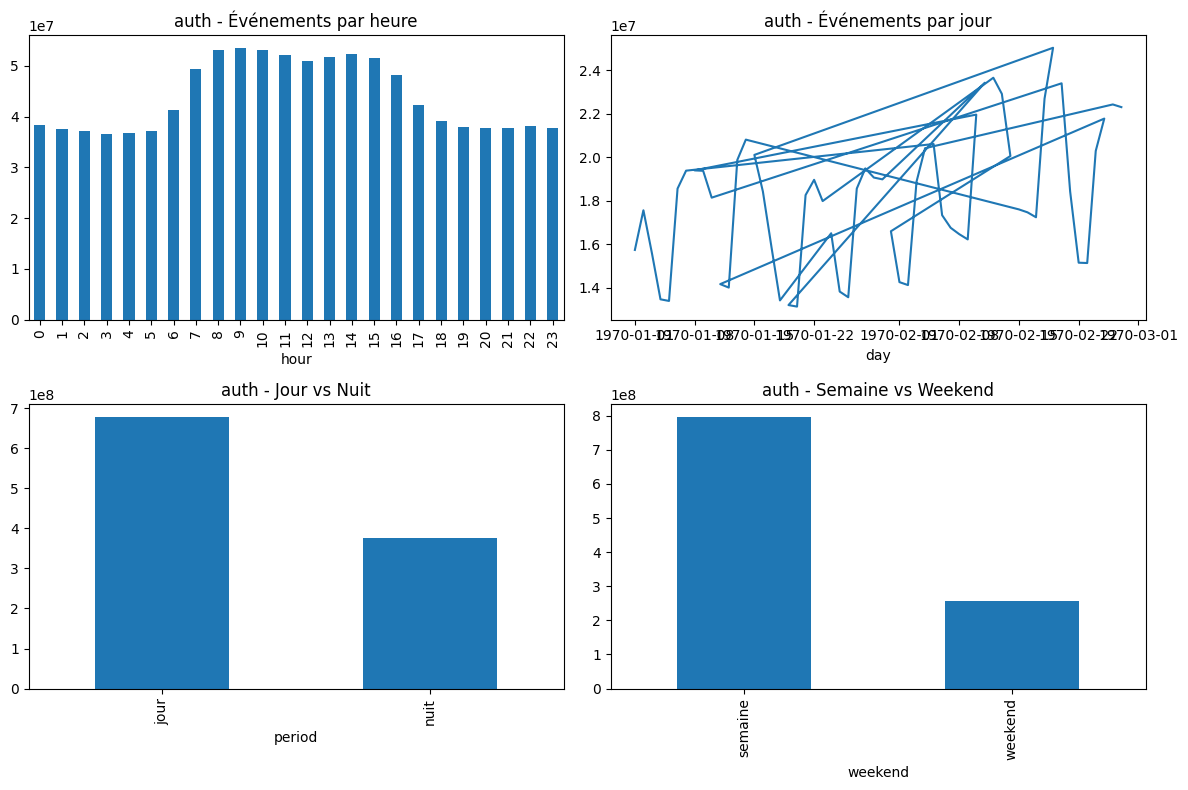


⏱️ Analyse temporelle pour PROC


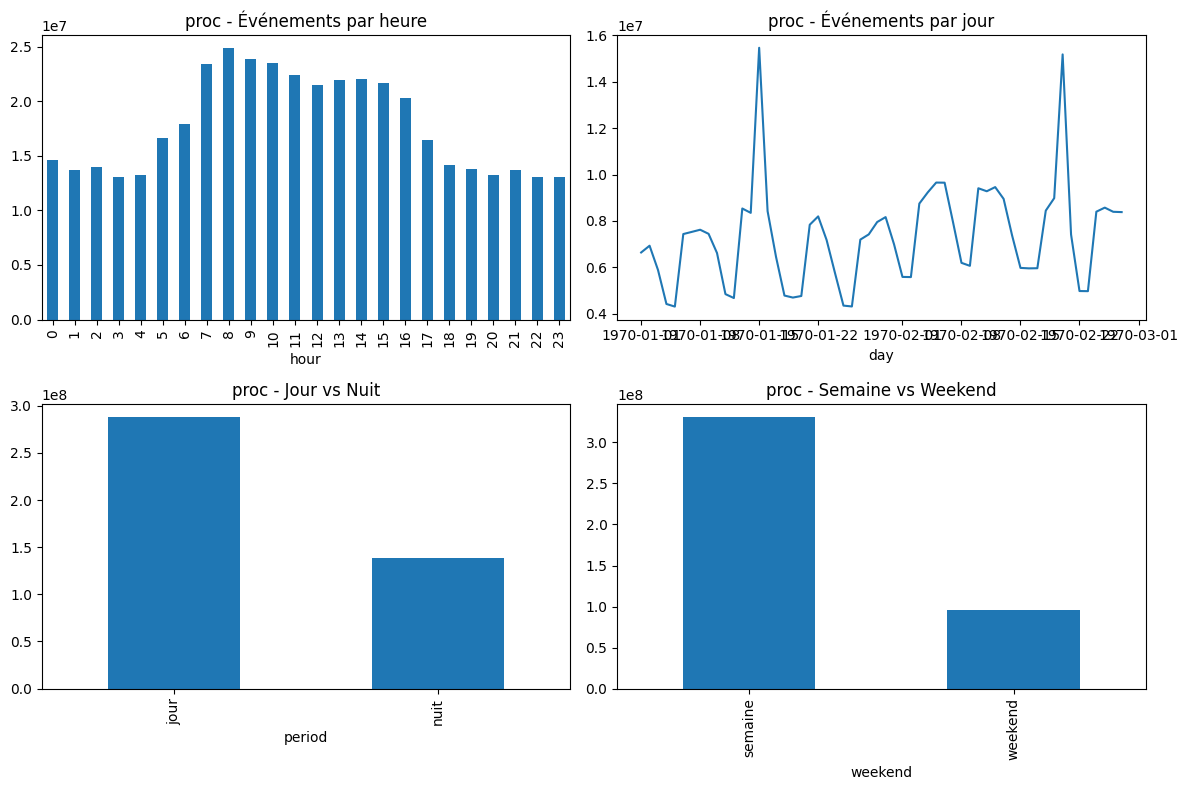


⏱️ Analyse temporelle pour FLOWS


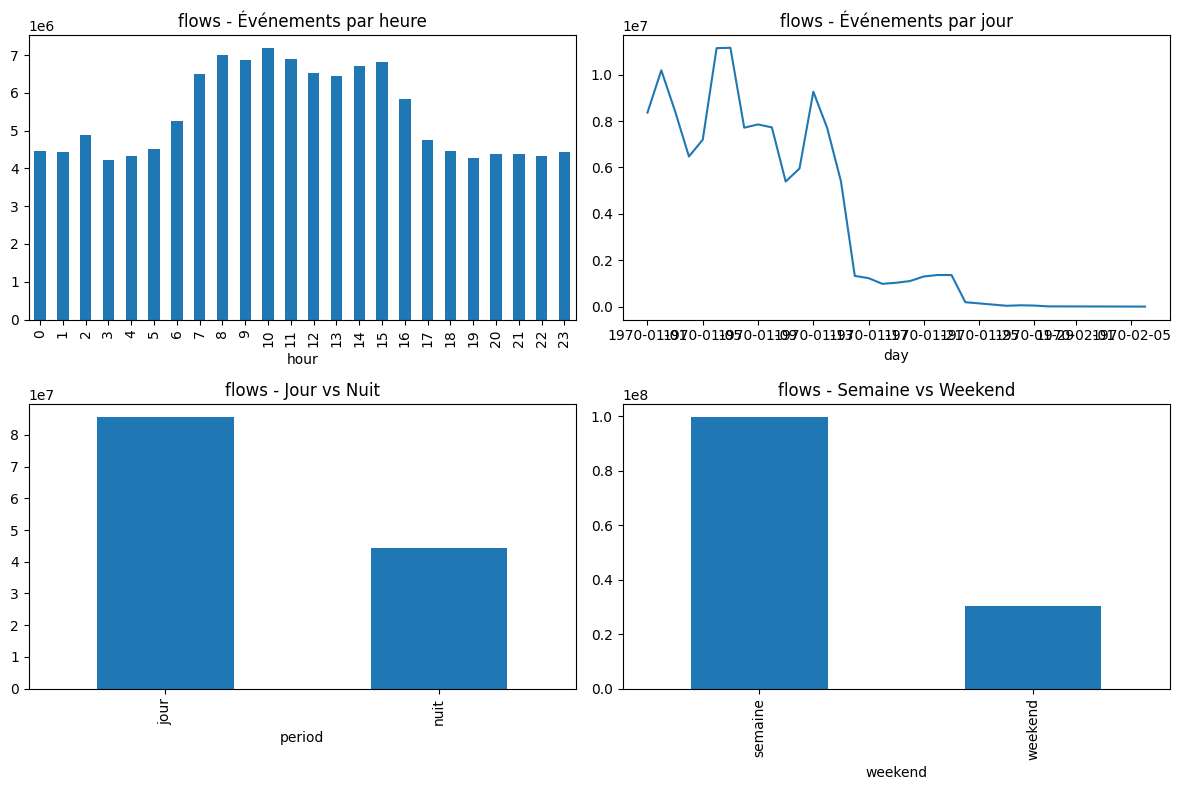


⏱️ Analyse temporelle pour DNS


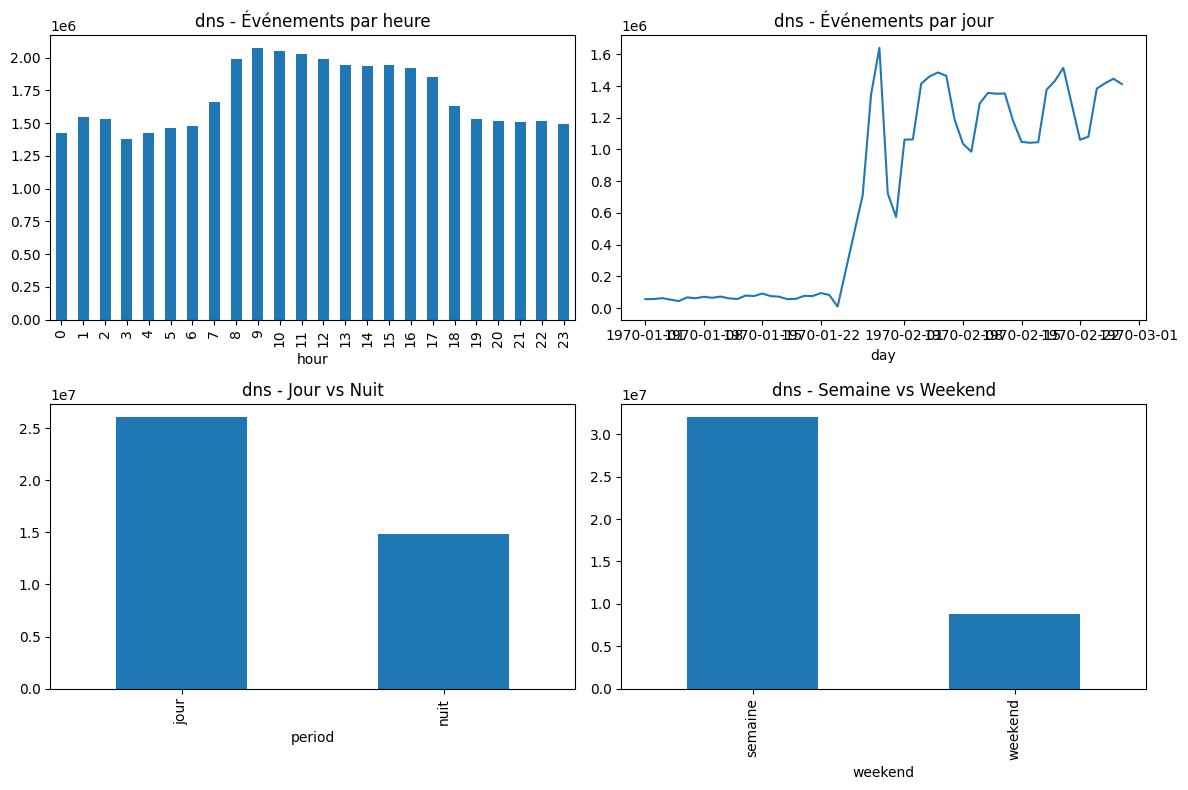


⏱️ Analyse temporelle pour REDTEAM


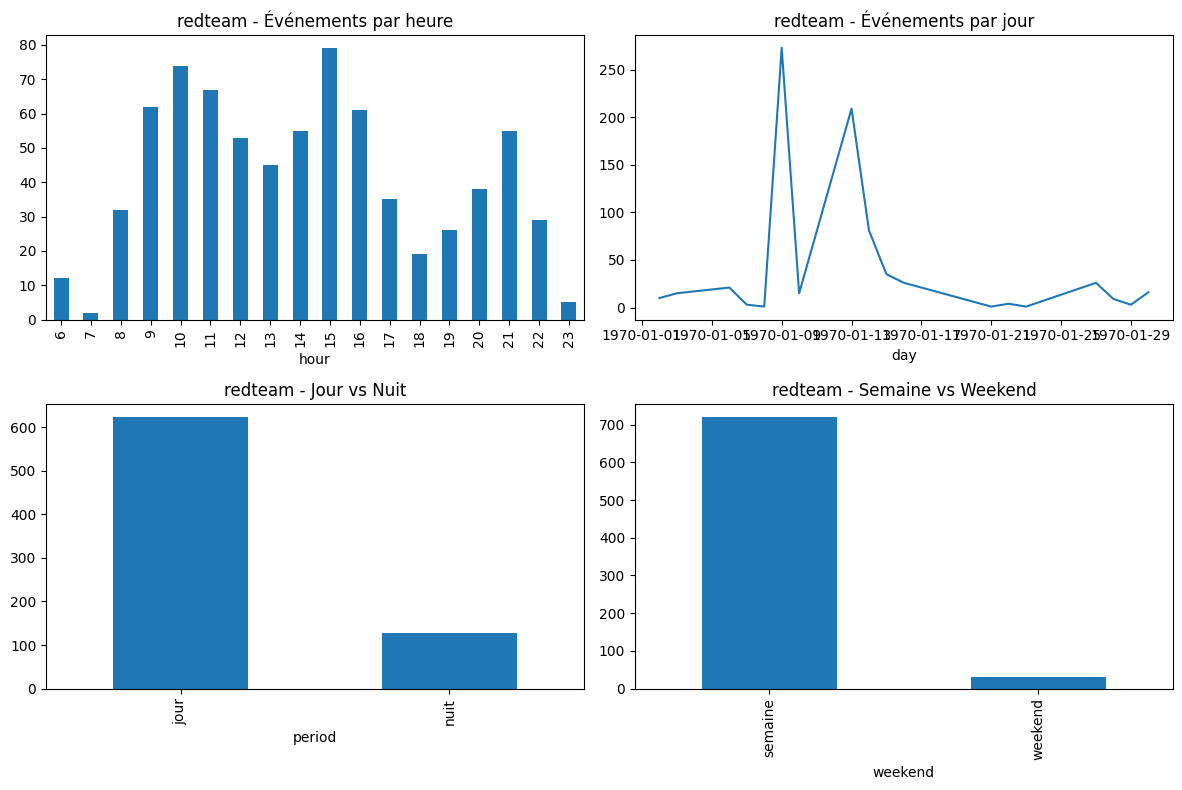

In [ ]:
# Fonction générique d'analyse temporelle
def analyse_temporelle(df, nom):
    print(f"\n Analyse temporelle pour {nom.upper()}")

    # Conversion en datetime
    if 'timestamp' not in df.columns:
        df['timestamp'] = dd.to_datetime(df['time'], unit='s')

    # Extraction des composantes temporelles
    df['hour'] = df['timestamp'].dt.hour   # en heure
    df['day'] = df['timestamp'].dt.date     # en jour
    df['weekday'] = df['timestamp'].dt.weekday  # 0 = lundi, 6 = dimanche

    # Période jour/nuit
    df['period'] = df['hour'].map_partitions(lambda s: s.apply(lambda h: 'jour' if 6 <= h < 20 else 'nuit'))

    # Weekend ou semaine
    df['weekend'] = df['weekday'].map_partitions(lambda s: s.apply(lambda d: 'weekend' if d >= 5 else 'semaine'))

    # Nombre d'evenements selon lheure,le jour, la periode ou le moment de la semaine
    hourly = df.groupby('hour').size().compute()
    daily = df.groupby('day').size().compute()
    period = df.groupby('period').size().compute()
    weekend = df.groupby('weekend').size().compute()

    # visualisation des 4 graphiques
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    hourly.plot(kind='bar', ax=axs[0, 0], title=f"{nom} - Événements par heure")
    daily.plot(ax=axs[0, 1], title=f"{nom} - Événements par jour")
    period.plot(kind='bar', ax=axs[1, 0], title=f"{nom} - Jour vs Nuit")
    weekend.plot(kind='bar', ax=axs[1, 1], title=f"{nom} - Semaine vs Weekend")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Application de la fonction à chaque source
analyse_temporelle(auth, "auth")
analyse_temporelle(proc, "proc")
analyse_temporelle(flows, "flows")
analyse_temporelle(dns, "dns")
analyse_temporelle(redteam, "redteam")


Identifier les fr´equences d’occurrence : top utilisateurs les plus actifs, machines les plus sollicit´ees, processus les plus fr´equents


🔝 Top 10 utilisateurs source (AUTH) les plus fréquents :
source_user@domain
ANONYMOUS LOGON@C586    17557999
U22@DOM1                16595241
U66@DOM1                11182081
C599$@DOM1               8492841
C1114$@DOM1              7714809
C104$@DOM1               6865894
C585$@DOM1               6790306
C743$@DOM1               5803554
C567$@DOM1               5090168
C1794$@DOM1              5054537
Name: count, dtype: int64[pyarrow]


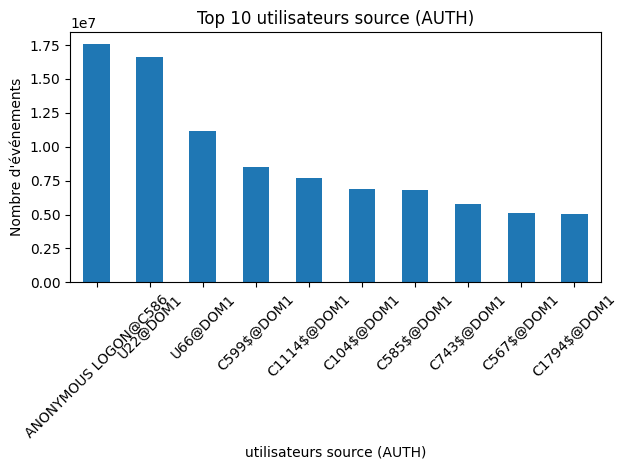


🔝 Top 10 utilisateurs destination (AUTH) les plus fréquents :
destination_user@domain
ANONYMOUS LOGON@C586    17557999
U22@DOM1                16595239
U66@DOM1                11184266
C599$@DOM1               8492841
C1114$@DOM1              7714809
C104$@DOM1               6865894
C585$@DOM1               6790311
C743$@DOM1               5803645
C567$@DOM1               5090168
C1794$@DOM1              5054537
Name: count, dtype: int64[pyarrow]


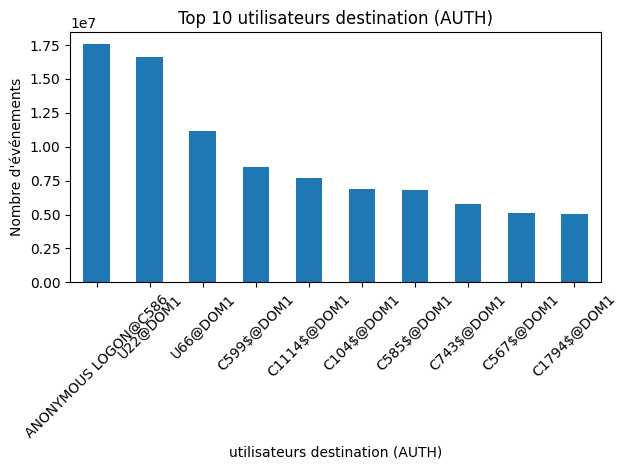


🔝 Top 10 machines source (AUTH) les plus fréquents :
source_computer
C586     55394572
C612     37899880
C529     36459263
C625     36384663
C467     36103345
C1065    34342700
C457     34060722
C528     27580920
C2106    18014851
C2162    11993020
Name: count, dtype: int64[pyarrow]


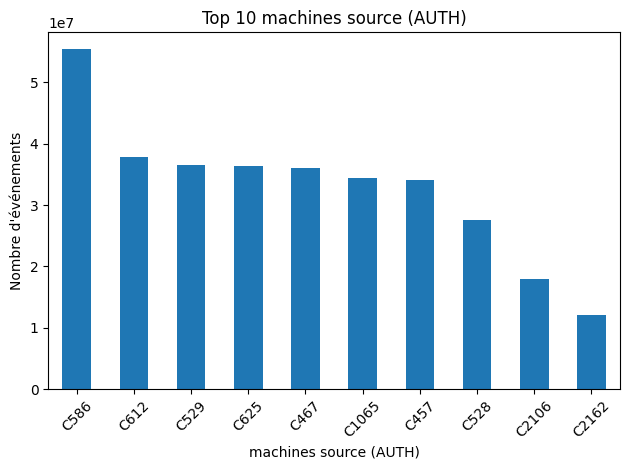


🔝 Top 10 machines destination (AUTH) les plus fréquents :
destination_computer
C586     121232326
C612      75369542
C529      72674773
C625      72161687
C467      71962942
C457      70586456
C1065     68549321
C528      55811015
C2106     33951104
C2162     22593994
Name: count, dtype: int64[pyarrow]


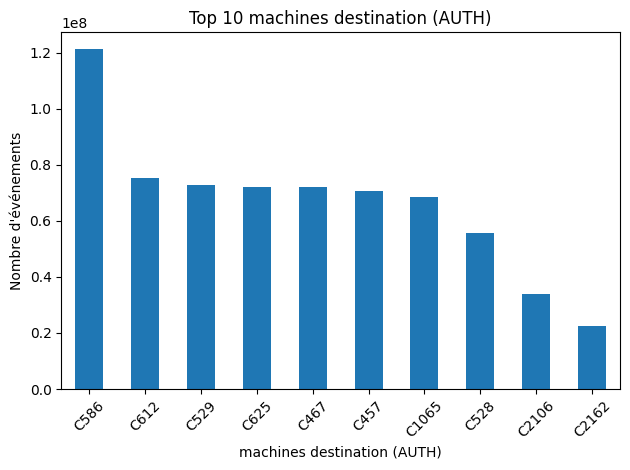


🔝 Top 10 utilisateurs (PROC) les plus fréquents :
user@domain
C5170$@DOM1     11599040
C3552$@DOM1     11386283
C1685$@DOM1      5790973
C1624$@DOM1      3335063
C236$@DOM1       2893576
C492$@DOM1       2270393
C1707$@DOM1      2027488
C20481$@DOM1     1962912
C972$@DOM1       1774822
C1432$@DOM1      1678802
Name: count, dtype: int64[pyarrow]


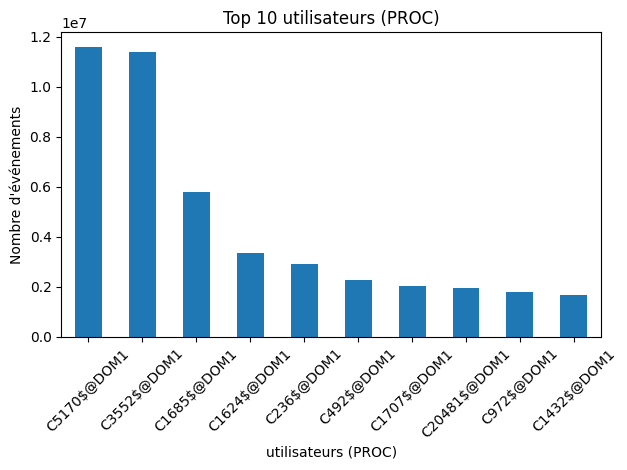


🔝 Top 10 machines (PROC) les plus fréquents :
computer
C5170     11599670
C15888    11388428
C1685      5794609
C1624      3338503
C236       2898379
C492       2276019
C1707      2029010
C20481     2019787
C972       1783308
C1432      1701402
Name: count, dtype: int64[pyarrow]


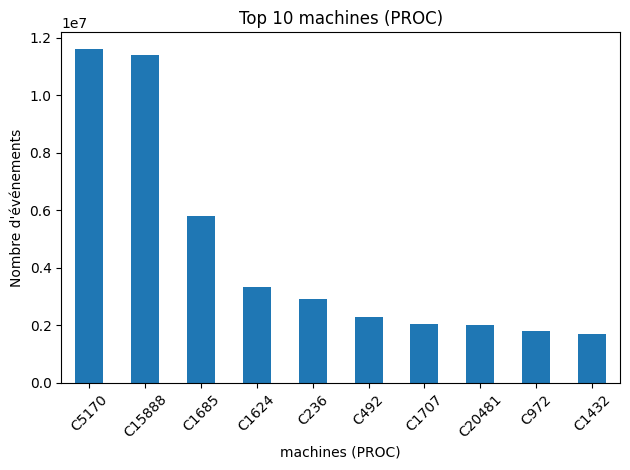


🔝 Top 10 processus (PROC) les plus fréquents :
process_name
P16     88999801
P5      44915544
P14     20480165
P265    20004346
P13     19744594
P25     16410259
P21     11263164
P7      10263232
P8       9145252
P10      8861093
Name: count, dtype: int64[pyarrow]


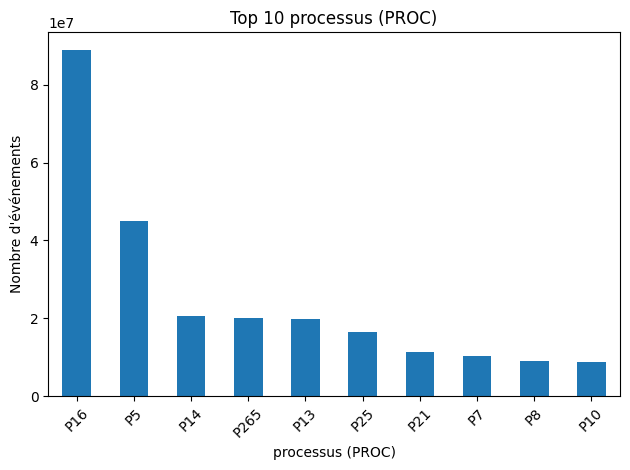


🔝 Top 10 machines source (FLOWS) les plus fréquents :
source_computer
C5721    5926416
C1707    5558718
C1685    5536501
C528     3981643
C5720    3558540
C586     3177336
C467     2766099
C2588    2664577
C706     2054844
C529     1712200
Name: count, dtype: int64[pyarrow]


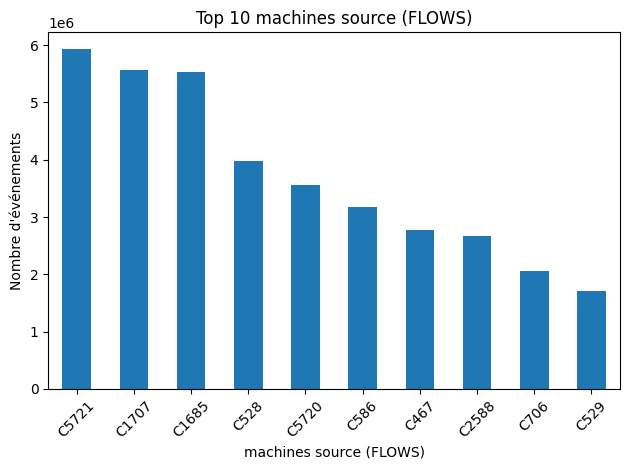


🔝 Top 10 machines destination (FLOWS) les plus fréquents :
destination_computer
C5721    11515183
C5720     9310452
C1707     5455219
C1685     5327443
C1549     3570626
C586      3233926
C2588     2665408
C706      2655720
C467      2530077
C585      1865855
Name: count, dtype: int64[pyarrow]


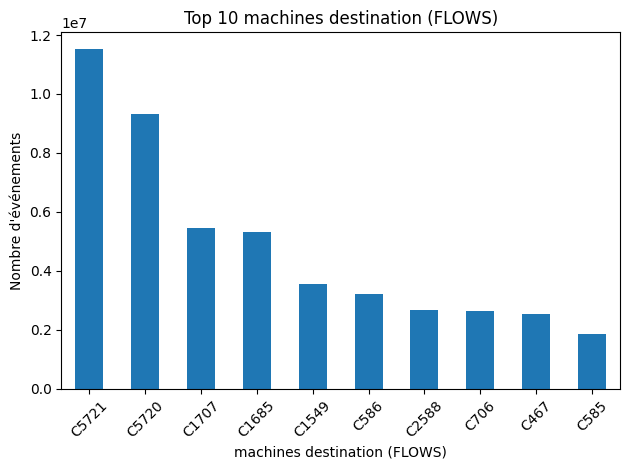


🔝 Top 10 machines source (DNS) les plus fréquents :
source_computer
C585      1624999
C743      1149807
C1823      391719
C5741      350885
C3380      163298
C17490     162708
C1193      149849
C22235     144637
C2091      140060
C561       138250
Name: count, dtype: int64[pyarrow]


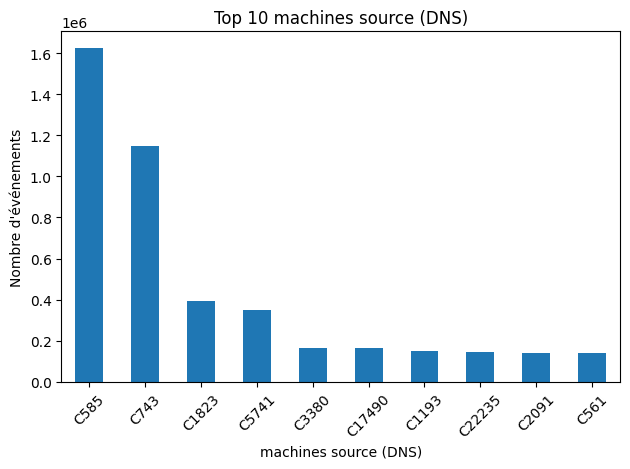


🔝 Top 10 machines résolues (DNS) les plus fréquents :
computer_resolved
C1707    5374369
C1685    5224450
C5030    4658033
C586     4489267
C754     2417026
C1025    2333557
C706     2098668
C1065     873480
C2189     843456
C457      820717
Name: count, dtype: int64[pyarrow]


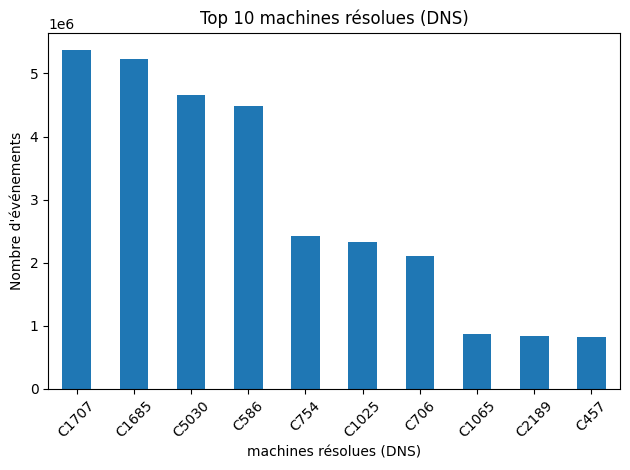


🔝 Top 10 utilisateurs (REDTEAM) les plus fréquents :
user@domain
U66@DOM1      118
U3005@DOM1     36
U737@DOM1      32
U1653@DOM1     31
U293@DOM1      31
U748@DOM1      26
U1723@DOM1     19
U8946@DOM1     19
U3635@DOM1     18
U2837@DOM1     15
Name: count, dtype: int64[pyarrow]


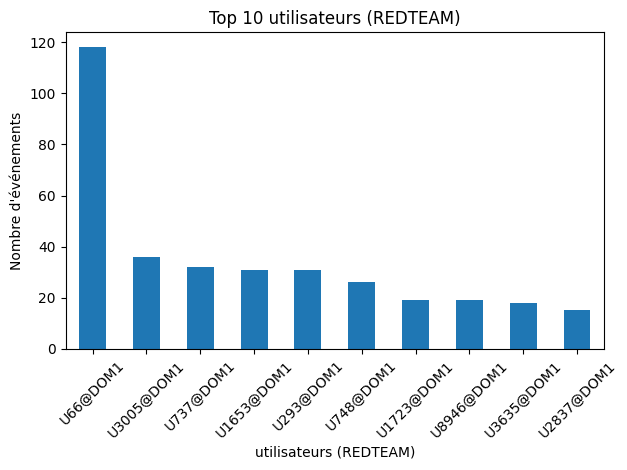


🔝 Top 10 machines source (REDTEAM) les plus fréquents :
source_computer
C17693    701
C22409     26
C19932     19
C18025      3
Name: count, dtype: int64[pyarrow]


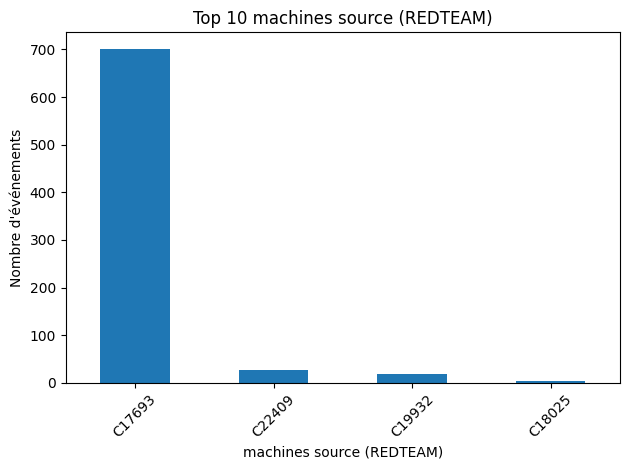


🔝 Top 10 machines destination (REDTEAM) les plus fréquents :
destination_computer
C2388     27
C754      26
C2519     21
C1015     15
C395      15
C19038    12
C1438     11
C92       11
C2079     10
C828      10
Name: count, dtype: int64[pyarrow]


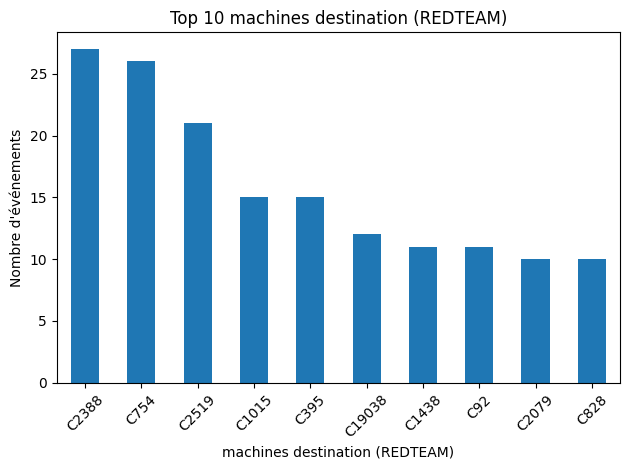

In [ ]:

# Fonction générique pour afficher les top N entités
def top_occurrences(df, col, label, n=10):
    top = df[col].value_counts().nlargest(n).compute()
    print(f"\n Top {n} {label} les plus fréquents :")
    print(top)
    top.plot(kind='bar', title=f"Top {n} {label}")
    plt.xlabel(label)
    plt.ylabel("Nombre d'événements")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# AUTH : utilisateurs et machines
top_occurrences(auth, 'source_user@domain', 'utilisateurs source (AUTH)')
top_occurrences(auth, 'destination_user@domain', 'utilisateurs destination (AUTH)')
top_occurrences(auth, 'source_computer', 'machines source (AUTH)')
top_occurrences(auth, 'destination_computer', 'machines destination (AUTH)')

# PROC : utilisateurs et processus
top_occurrences(proc, 'user@domain', 'utilisateurs (PROC)')
top_occurrences(proc, 'computer', 'machines (PROC)')
top_occurrences(proc, 'process_name', 'processus (PROC)')

# FLOWS : machines source/destination
top_occurrences(flows, 'source_computer', 'machines source (FLOWS)')
top_occurrences(flows, 'destination_computer', 'machines destination (FLOWS)')

# DNS : machines
top_occurrences(dns, 'source_computer', 'machines source (DNS)')
top_occurrences(dns, 'computer_resolved', 'machines résolues (DNS)')

# REDTEAM : utilisateurs et machines
top_occurrences(redteam, 'user@domain', 'utilisateurs (REDTEAM)')
top_occurrences(redteam, 'source_computer', 'machines source (REDTEAM)')
top_occurrences(redteam, 'destination_computer', 'machines destination (REDTEAM)')


Pour les authentifications, calculer les taux de succes/echec par utilisateurs et par machine

Vérifie les valeurs réelles dans auth['success/failure'] :

In [12]:
auth['success/failure'].value_counts().compute()

success/failure
Fail         12840308
Success    1038590150
Name: count, dtype: int64[pyarrow]

In [ ]:
# 'auth' est votre dask.dataframe qui existe déjà

print("Adaptation du DataFrame Dask...")

try:
    # 1. Renommer les colonnes pour une manipulation plus facile
    #    Ceci est une opération paresseuse.
    auth_renamed = auth.rename(columns={
        'source_user@domain': 'src_user',
        'destination_computer': 'dest_machine',
        'success/failure': 'status'
    })

    # 2. Créer une colonne 'is_fail' (1 pour échec, 0 pour succès)
    #    .assign() est la méthode paresseuse pour ajouter une colonne
    auth_with_fail = auth_renamed.assign(
        is_fail=(auth_renamed['status'] == 'Fail').astype(int)
    )

    print("Définition des calculs paresseux...")

    # 3. Définir le calcul du taux par utilisateur (sur 'src_user')
    user_agg = auth_with_fail.groupby('src_user').agg(
        total_auths=('is_fail', 'count'),  # Nombre total d'authentifications
        failed_auths=('is_fail', 'sum'),   # Somme des 1 = nombre d'échecs
        failure_rate=('is_fail', 'mean') # Moyenne des 1/0 = taux d'échec
    )

    # 4. Définir le calcul du taux par machine (sur 'dest_machine')
    machine_agg = auth_with_fail.groupby('dest_machine').agg(
        total_auths=('is_fail', 'count'),
        failed_auths=('is_fail', 'sum'),
        failure_rate=('is_fail', 'mean')
    )

    # 5. Exécuter les deux calculs en parallèle
    print("Exécution des calculs sur l'ensemble des données...")
    # dask.compute() exécute les deux graphiques de tâches
    (user_rates_df, machine_rates_df) = dask.compute(user_agg, machine_agg)
    print("Calculs terminés.")

    # 6. Ajouter les taux de succès (maintenant sur les DataFrames pandas)
    user_rates_df['success_rate'] = 1.0 - user_rates_df['failure_rate']
    machine_rates_df['success_rate'] = 1.0 - machine_rates_df['failure_rate']

    # 7. Afficher les résultats
    print("\n--- Top 5 des utilisateurs par taux d'échec ---")
    print(user_rates_df.sort_values('failure_rate', ascending=False).head(10))

    print("\n--- Top 5 des machines (destination) par taux d'échec ---")
    print(machine_rates_df.sort_values('failure_rate', ascending=False).head(10))

except Exception as e:
    print(f"Une erreur est survenue : {e}")
    print("Vérifiez que les colonnes 'source_user@domain', 'destination_computer',")
    print("et 'success/failure' existent bien dans votre DataFrame 'auth'.")
    print("Vérifiez aussi que la valeur 'Fail' est correcte.")

Visualisation des taux d’échec

C:\Users\User\AppData\Local\Temp\ipykernel_10016\2481550286.py:26: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_10016\2481550286.py:26: UserWarning: Glyph 128421 (\N{DESKTOP COMPUTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128421 (\N{DESKTOP COMPUTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


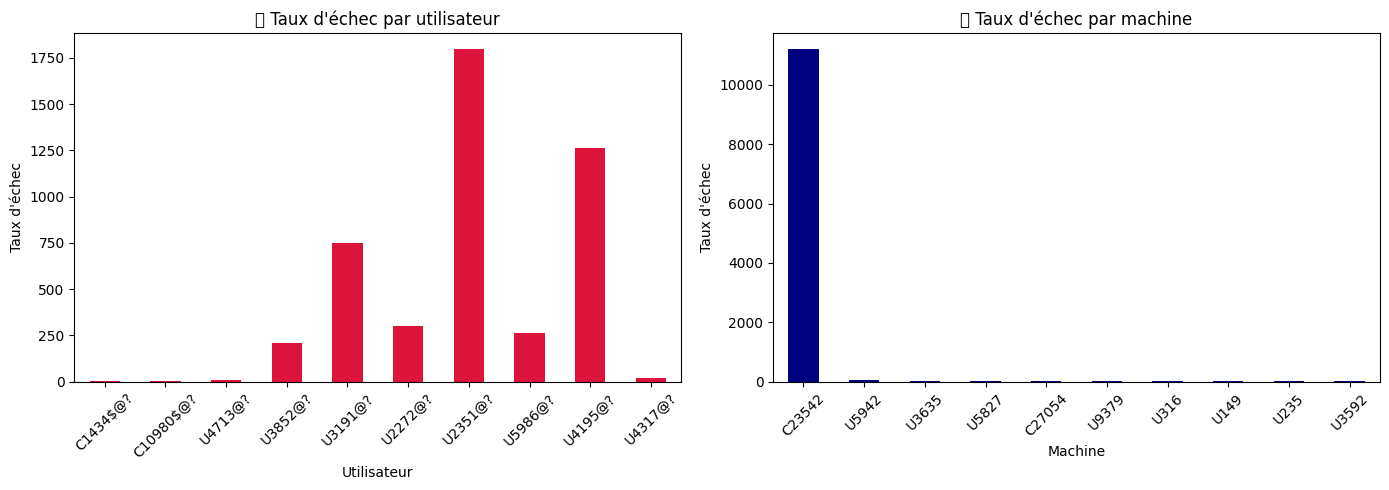

In [ ]:
import matplotlib.pyplot as plt

# Sélection des 10 utilisateurs avec le taux d’échec le plus élevé
top_users = user_rates_df.sort_values('failure_rate', ascending=False).head(10)

# Sélection des 10 machines avec le taux d’échec le plus élevé
top_machines = machine_rates_df.sort_values('failure_rate', ascending=False).head(10)

# Création des graphiques
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Utilisateurs
top_users['failed_auths'].plot(kind='bar', ax=axs[0], color='crimson')
axs[0].set_title("Taux d'échec par utilisateur")
axs[0].set_ylabel("Taux d'échec")
axs[0].set_xlabel("Utilisateur")
axs[0].tick_params(axis='x', rotation=45)

# Machines
top_machines['failed_auths'].plot(kind='bar', ax=axs[1], color='navy')
axs[1].set_title("Taux d'échec par machine")
axs[1].set_ylabel("Taux d'échec")
axs[1].set_xlabel("Machine")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [9]:
# Agrégation CORRECTE avec Polars
volume_trafic = flows.group_by('source_computer').agg([
    pl.sum('byte_count').alias('volume_total_bytes'),
    pl.sum('packet_count').alias('total_packets')
])

print(volume_trafic.head())

shape: (5, 3)
┌─────────────────┬────────────────────┬───────────────┐
│ source_computer ┆ volume_total_bytes ┆ total_packets │
│ ---             ┆ ---                ┆ ---           │
│ str             ┆ i64                ┆ i64           │
╞═════════════════╪════════════════════╪═══════════════╡
│ C11475          ┆ 10115263           ┆ 51085         │
│ C5941           ┆ 28037653           ┆ 320618        │
│ C2954           ┆ 19547              ┆ 66            │
│ C20151          ┆ 59872348           ┆ 319851        │
│ C3380           ┆ 117202             ┆ 184           │
└─────────────────┴────────────────────┴───────────────┘


## 3. Reduction dimensionnelle et visualisation :